In [49]:
import pandas as pd
import numpy as np
from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score
from numpy import clip, column_stack, argmax

In [50]:
Train = pd.read_csv('dataTrain.csv')
Test = pd.read_csv('dataTest.csv')

X_train = Train.drop('output', axis=1)
y_train = Train['output']

X_test = Test.drop('output', axis=1)
y_test = Test['output']

maxs = X_train.max().tolist()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((241, 13), (61, 13), (241,), (61,))

In [51]:
cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=2)
clust_centers, part_matrix, _ = cl.cluster(method='fcm')
part_matrix.shape

(241, 2)

In [52]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.array
y_test = y_test.array

In [53]:
ae = AntecedentEstimator(X_train, part_matrix)
antecedent_params = ae.determineMF()

In [54]:
ce = ConsequentEstimator(X_train, y_train, part_matrix)
conseq_params = ce.suglms()

In [55]:
var_names = data.columns[:-1].to_list()
var_names

['age',
 'sex',
 'cp',
 'trtbps',
 'chol',
 'fbs',
 'restecg',
 'thalachh',
 'exng',
 'oldpeak',
 'slp',
 'caa',
 'thall']

In [56]:
modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=False)
model = modbuilder.get_model()

 * Detected 2 rules / clusters
 * Detected Sugeno model type


In [57]:
model.get_rules()

['IF ((age IS cluster1) AND ((sex IS cluster1) AND ((cp IS cluster1) AND ((trtbps IS cluster1) AND ((chol IS cluster1) AND ((fbs IS cluster1) AND ((restecg IS cluster1) AND ((thalachh IS cluster1) AND ((exng IS cluster1) AND ((oldpeak IS cluster1) AND ((slp IS cluster1) AND ((caa IS cluster1) AND (thall IS cluster1))))))))))))) THEN (OUTPUT IS fun1)',
 'IF ((age IS cluster2) AND ((sex IS cluster2) AND ((cp IS cluster2) AND ((trtbps IS cluster2) AND ((chol IS cluster2) AND ((fbs IS cluster2) AND ((restecg IS cluster2) AND ((thalachh IS cluster2) AND ((exng IS cluster2) AND ((oldpeak IS cluster2) AND ((slp IS cluster2) AND ((caa IS cluster2) AND (thall IS cluster2))))))))))))) THEN (OUTPUT IS fun2)']

In [58]:
# example of how pyFUME defines une linguistic variable in simpful
model._lvs['age']

<Linguistic variable 'age', contains fuzzy sets [<Fuzzy set (function), term='cluster1'>, <Fuzzy set (function), term='cluster2'>], universe of discourse: None>

In [59]:
model.get_rules()

['IF ((age IS cluster1) AND ((sex IS cluster1) AND ((cp IS cluster1) AND ((trtbps IS cluster1) AND ((chol IS cluster1) AND ((fbs IS cluster1) AND ((restecg IS cluster1) AND ((thalachh IS cluster1) AND ((exng IS cluster1) AND ((oldpeak IS cluster1) AND ((slp IS cluster1) AND ((caa IS cluster1) AND (thall IS cluster1))))))))))))) THEN (OUTPUT IS fun1)',
 'IF ((age IS cluster2) AND ((sex IS cluster2) AND ((cp IS cluster2) AND ((trtbps IS cluster2) AND ((chol IS cluster2) AND ((fbs IS cluster2) AND ((restecg IS cluster2) AND ((thalachh IS cluster2) AND ((exng IS cluster2) AND ((oldpeak IS cluster2) AND ((slp IS cluster2) AND ((caa IS cluster2) AND (thall IS cluster2))))))))))))) THEN (OUTPUT IS fun2)']

In [60]:
# The pyFUME library doesn't atribute a universe of discourse to the linguistic variables it creates in simpful. In order to fix this, we set each universe considering the maximum
# value heald by each dataframe column. This has to be done since, otherwise, the plotting functions won't work.

for ix in range(len(var_names)):
    max = maxs[ix]
    uod = [0, max * 1.1]
    model._lvs[var_names[ix]]._universe_of_discourse = uod


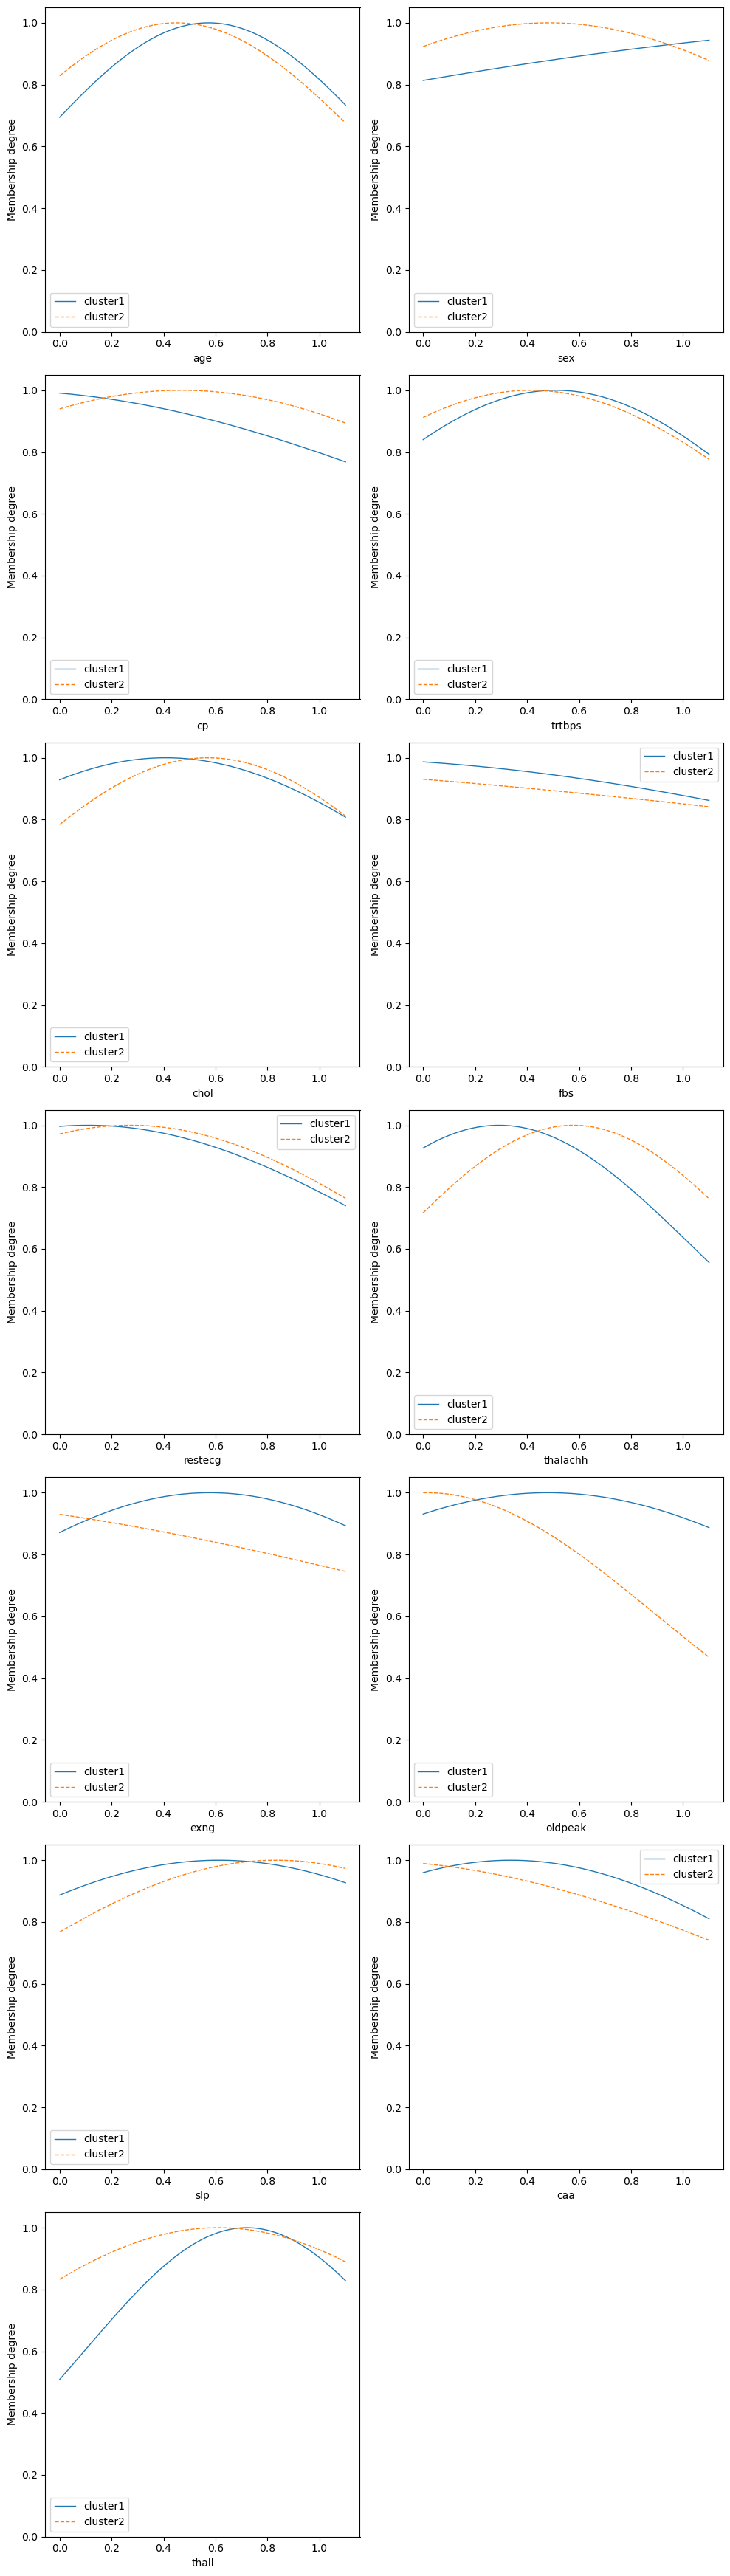

In [61]:
model.produce_figure("",2)

In [62]:
modtester = SugenoFISTester(model, X_test, var_names)
y_pred_probs = clip(modtester.predict()[0], 0, 1)
y_pred_probs = column_stack((1 - y_pred_probs, y_pred_probs))
y_pred = argmax(y_pred_probs,axis=1)

In [63]:
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy: {:.3f}".format(acc_score))
rec_score = recall_score(y_test, y_pred)
print("Recall: {:.3f}".format(rec_score))
prec_score = precision_score(y_test, y_pred)
print("Precision Score: {:.3f}".format(prec_score))
F1_score = f1_score(y_test, y_pred)
print("F1-Score: {:.3f}".format(F1_score))
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Score: {:.3f}".format(kappa))

Accuracy: 0.836
Recall: 0.844
Precision Score: 0.844
F1-Score: 0.844
Kappa Score: 0.671
